# Using DBSCAN for the clustering of 2D blobs - A simple example

*Costas Andreopoulos \<c.andreopoulos@cern.ch\>*

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from scipy.spatial import ConvexHull


**Generate and plot synthetic data**

In [2]:
n_samples = 300
n_features = 2
n_true_clusters = 5
random_state = 40

X, Y = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_true_clusters, random_state=random_state)

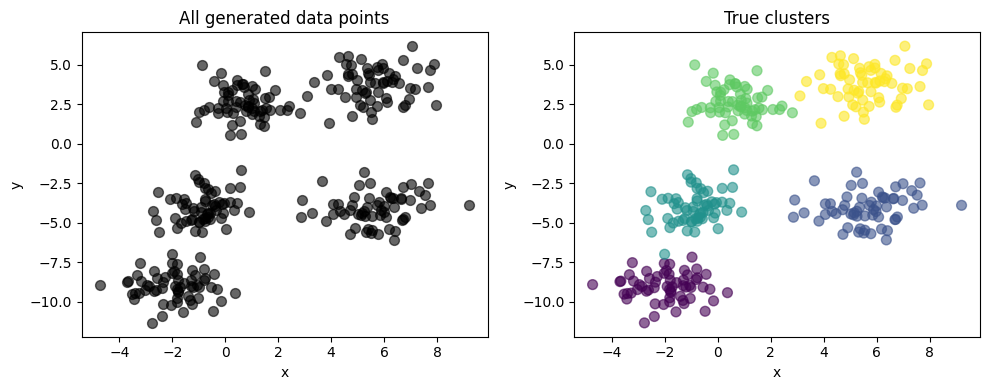

In [3]:
fig = plt.figure(figsize=(10,4))
gs = gridspec.GridSpec(1,2,width_ratios=[1,1])
axL = fig.add_subplot(gs[0,0])
axL.scatter(X[:, 0], X[:, 1], color='black', s=50, alpha=0.6)
axL.set_title('All generated data points')
axL.set_xlabel("x")
axL.set_ylabel("y")
axR = fig.add_subplot(gs[0,1])
axR.scatter(X[:, 0], X[:, 1], c=Y, cmap='viridis', s=50, alpha=0.6)
axR.set_title('True clusters')
axR.set_xlabel("x")
axR.set_ylabel("y")
plt.tight_layout()
plt.show()

**Tuning DBSCAN**

Unlike the k-Means and Gaussian Mixture algorithm, where the optimal number of clusters is an input, 
and it is evaluated using the **Elbow method** heuristic (for kMeans), or one of the
the **Bayesian Information Criterion (BIC)** or **Akaike Information Criterion (AIC)** (for Gaussian Mixture),
DBSCAN  does not require specifying the number of clusters.

DBSCAN uses two hyper-parameters that require tuning:
  * **epsilon radius**, which defines the maximum distance between points in a cluster, and
  * **min_samples**, which defines the minimum number of points to form a cluster.

For min_samples, a usual rule of thumb is to set it to a number which is about twice the number of features. Then, it should be increased if the algorithm splits clusters too aggressively, and should be decreased if too many points are labelled as *noise*.

A common method to tune the epsilon radius is by making the **k-distance** plot, and looking for an elbow where the distance starts to increase rapidly. This is a good choice for the epsilon radius.

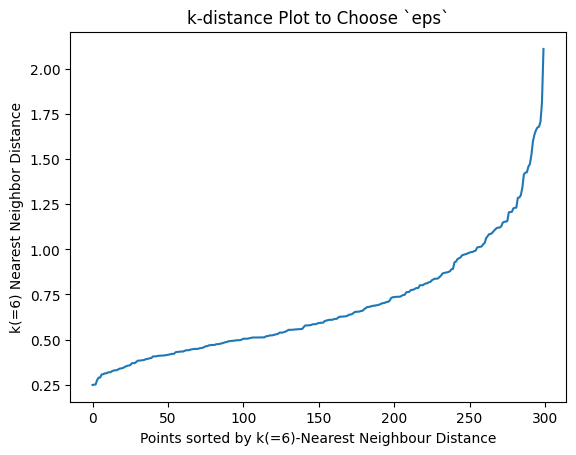

In [4]:
# Common initial choice for min_samples
min_samples = 5

# Build the k-distance plot to tune the epsilon radius
neighbours = NearestNeighbors(n_neighbors=min_samples+1) # +1 because point P itself is included in the search for the nearest neighbours to P
neighbours.fit(X) # Find the min_samples closest points to all points in X
distances, indices = neighbours.kneighbors(X) # Return the distances and the indices of the min_samples closest points
# Sort and plot k-distances
last_neighbour_distances = np.sort(distances[:, -1])  # Sort by last neighbor
plt.plot(last_neighbour_distances)
plt.xlabel(f"Points sorted by k(={min_samples+1})-Nearest Neighbour Distance")
plt.ylabel(f"k(={min_samples+1}) Nearest Neighbor Distance")
plt.title("k-distance Plot to Choose `eps`")
plt.show()

**Run DBSCAN for the optimal values of hyperparameters**

In [5]:
# Looking at the above plot, select the epsilon radius
eps = 1.0

# Apply DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
Y_dbscan = dbscan.fit_predict(X)

# Print DBSCAN clustering information 
n_clusters_found = len(set(Y_dbscan)) - (1 if -1 in Y_dbscan else 0) # count unique cluster labels, but ignore -1 (if any) as it is noise
n_noise_points = np.sum(Y_dbscan == -1)
noise_ratio = n_noise_points / len(Y_dbscan)
print(f"Number of clusters found: {n_clusters_found}")
print(f"Noise Points: {n_noise_points} ({noise_ratio:.2%} of all data points)")

Number of clusters found: 5
Noise Points: 6 (2.00% of all data points)


**Visualize the DBSCAN clusters**

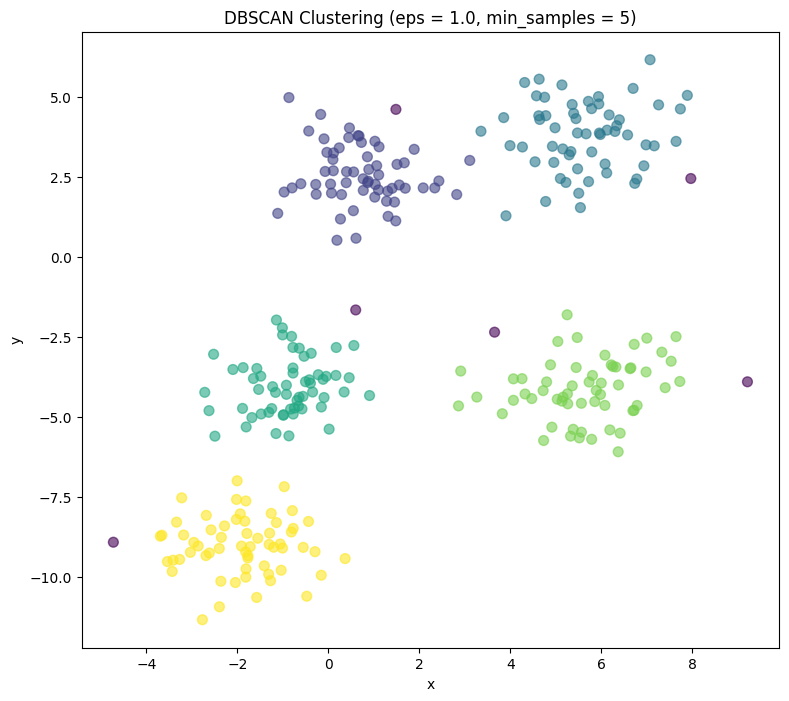

In [6]:
plt.figure(figsize=(9,8))
plt.scatter(X[:, 0], X[:, 1], c=Y_dbscan, cmap='viridis', s=50, alpha=0.6)
# plt.scatter(gmm.means_[:, 0], gmm.means_[:, 1], s=200, c='red', marker='X', label='Centroids')
plt.title(f"DBSCAN Clustering (eps = {eps}, min_samples = {min_samples})")
# plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

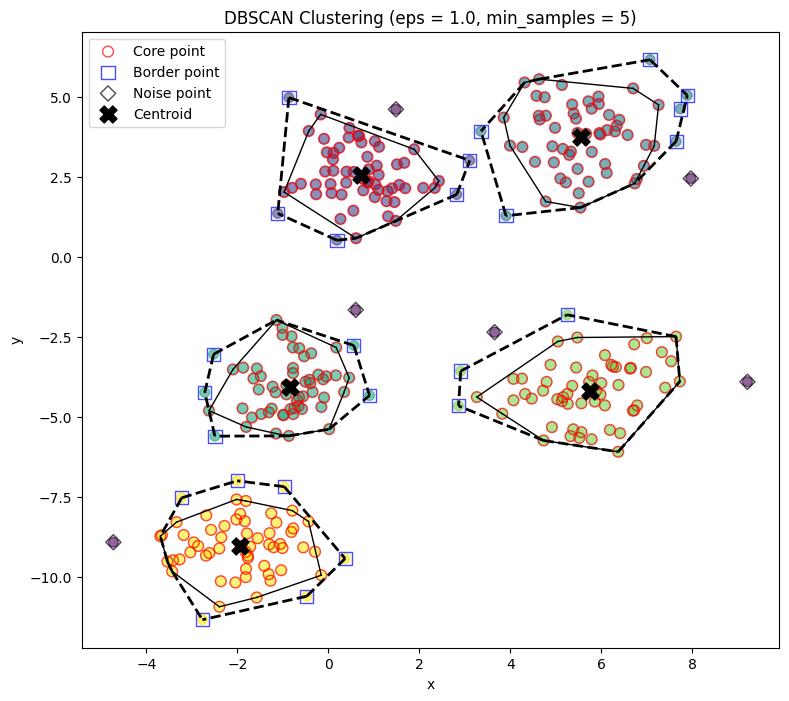

In [7]:
# Redo the above plot, but mark `core', `border', and `noise' points, plot cluster centroids, and the convex hull around core points 

# Plot clusters
plt.figure(figsize=(9,8))
plt.scatter(X[:, 0], X[:, 1], c=Y_dbscan, cmap='viridis', s=50, alpha=0.6)

# Figure out `core', `border' and `noise' points, and mark them on the plot of clusters 
core_mask      = np.zeros_like(Y_dbscan, dtype=bool)
border_mask    = np.zeros_like(Y_dbscan, dtype=bool)
noise_mask     = np.zeros_like(Y_dbscan, dtype=bool)
not_noise_mask = np.zeros_like(Y_dbscan, dtype=bool)
core_mask      [dbscan.core_sample_indices_]   = True
border_mask    [(Y_dbscan != -1) & ~core_mask] = True
noise_mask     [Y_dbscan == -1]                = True
not_noise_mask [Y_dbscan > -1]                 = True
X_core            = X[core_mask]
Y_core            = Y_dbscan[core_mask]
X_border          = X[border_mask]
X_core_or_border  = X[not_noise_mask]
Y_core_or_border  = Y_dbscan[not_noise_mask]
X_noise           = X[noise_mask]
plt.scatter(X_core   [:, 0], X_core   [:, 1], facecolor='none',  edgecolors='red',   marker='o', s=60,  alpha=0.7, label="Core point")
plt.scatter(X_border [:, 0], X_border [:, 1], facecolor='none',  edgecolors='blue',  marker='s', s=90,  alpha=0.7, label="Border point")
plt.scatter(X_noise  [:, 0], X_noise  [:, 1], facecolor='none',  edgecolors='black', marker='D', s=60,  alpha=0.7, label="Noise point")

# Calculate the median centroids 
# (centroids are not computed explicitly by DBSCAN, they are not used in clustering, and they don't always make sense)
unique_clusters = set(Y_dbscan) - {-1}  # Exclude noise
centroids = []
for cluster in unique_clusters:
    cluster_core_points = X_core[Y_core == cluster] 
    centroids.append(cluster_core_points.mean(axis=0))
centroids = np.array(centroids) # convert to numpy array
plt.scatter(centroids[:, 0], centroids[:, 1], facecolor='black', edgecolors='black', marker='X', s=150, alpha=1.0, label='Centroid')

# Calculate the convex hull enclosing the core and the core+border points for each cluster
for cluster in unique_clusters:
    cluster_core_points           = X_core           [Y_core           == cluster] 
    cluster_core_or_border_points = X_core_or_border [Y_core_or_border == cluster] 
    if len(cluster_core_points > 3): # need at least 3 points for a convex hull
        hull_core = ConvexHull(cluster_core_points)
        for simplex in hull_core.simplices:  # Draw hull edges
            plt.plot(cluster_core_points[simplex, 0], cluster_core_points[simplex, 1], 'k-', linewidth=1)
        hull_core_border = ConvexHull(cluster_core_or_border_points)
        for simplex in hull_core_border.simplices: 
            plt.plot(cluster_core_or_border_points[simplex, 0], cluster_core_or_border_points[simplex, 1], 'k--', linewidth=2)

plt.title(f"DBSCAN Clustering (eps = {eps}, min_samples = {min_samples})")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

The **silhouette score** for the data point $i$ is given by

$\displaystyle S{i} = \frac{b(i)-a(i)}{max\{b(i),a(i)\}}$

where $a(i)$ is the average distance between the point $i$ and all other points in its cluster, whereas $b(i)$ is the average distance between i and all points in the nearest cluster.

Average silhouette score for DBSCAN clustering: 0.65


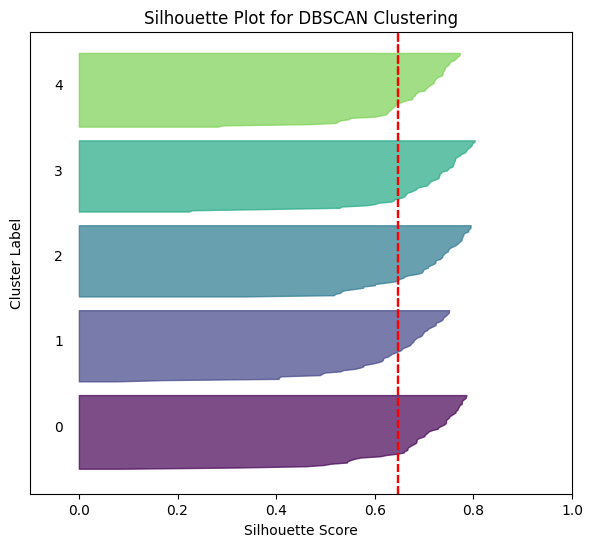

In [8]:
def plot_silhouette_score(X, Y_cluster, n_clusters, cluster_algo_label, ax):
    """
    Plot the silhouette score for every data point. Sort the points according to the score and group in assigned clusters.
    Compare with the average silhouette score.
    """
    # Compute the average silhouette score
    slsc_av = silhouette_score(X, Y_cluster)
    print(f"Average silhouette score for {cluster_algo_label} clustering: {slsc_av:.2f}")
    
    # Get the silhouette score for each point
    slsc = silhouette_samples(X, Y_cluster)

    y_lower =  0 
    y_upper = 10 
    for i in range(n_clusters):
        # Get the sillhouete scores for all points in current cluster and sort them
        slsc_cl = slsc[Y_cluster == i]
        slsc_cl.sort()    
        # Color a band between x = 0 and x = silhouette score, for each data point in the current cluster
        y_lower = y_upper + 10
        y_upper = y_lower + len(slsc_cl)    
        color = cm.viridis(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, slsc_cl, facecolor=color, edgecolor=color, alpha=0.7)    
        ax.text(-0.05, y_lower + 0.5 * len(slsc_cl), str(i))    

        # Add a line showing the average silhouette score 
        ax.axvline(slsc_av, color="red", linestyle="--")

        ax.set_xlabel("Silhouette Score")
        ax.set_ylabel("Cluster Label")
        ax.set_title(f"Silhouette Plot for {cluster_algo_label} Clustering")
        ax.set_xlim([-0.1, 1])
        ax.set_ylim([0, len(X) + (n_clusters + 2) * 10])
        ax.set_yticks([])

fig, ax = plt.subplots(figsize=(7,6))
plot_silhouette_score(X, Y_dbscan, n_clusters_found, "DBSCAN", ax)